# ***AI5100 : DEEP LEARNING***

# ***Surveillance Through Face Detection***

## ***Pre-Trained mtcnn Model Usage***

In [ ]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 2.3 MB 4.9 MB/s 


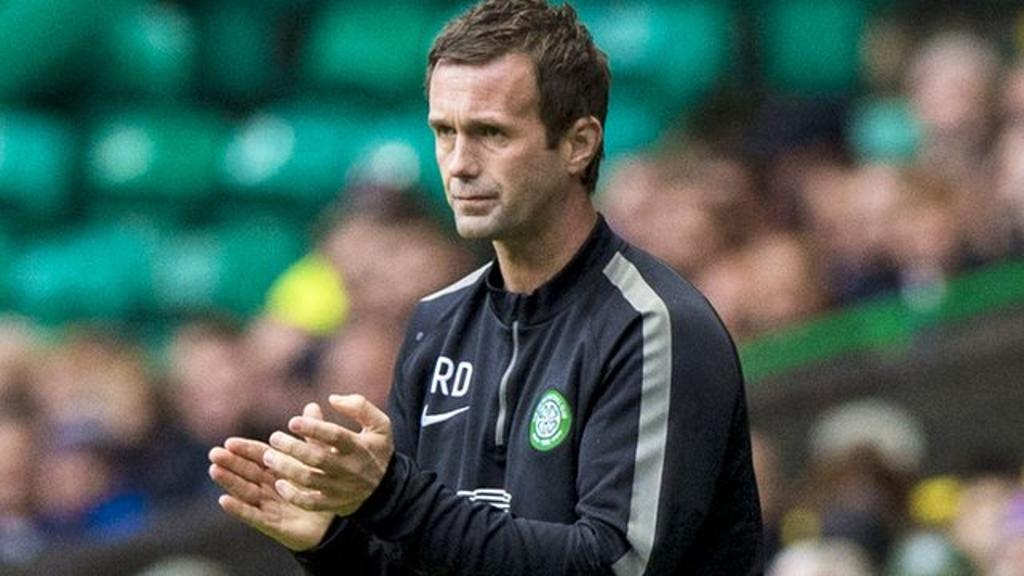

[{'box': [429, 69, 124, 162], 'confidence': 0.9999746084213257, 'keypoints': {'left_eye': (444, 132), 'right_eye': (495, 132), 'nose': (455, 169), 'mouth_left': (453, 198), 'mouth_right': (496, 197)}}]


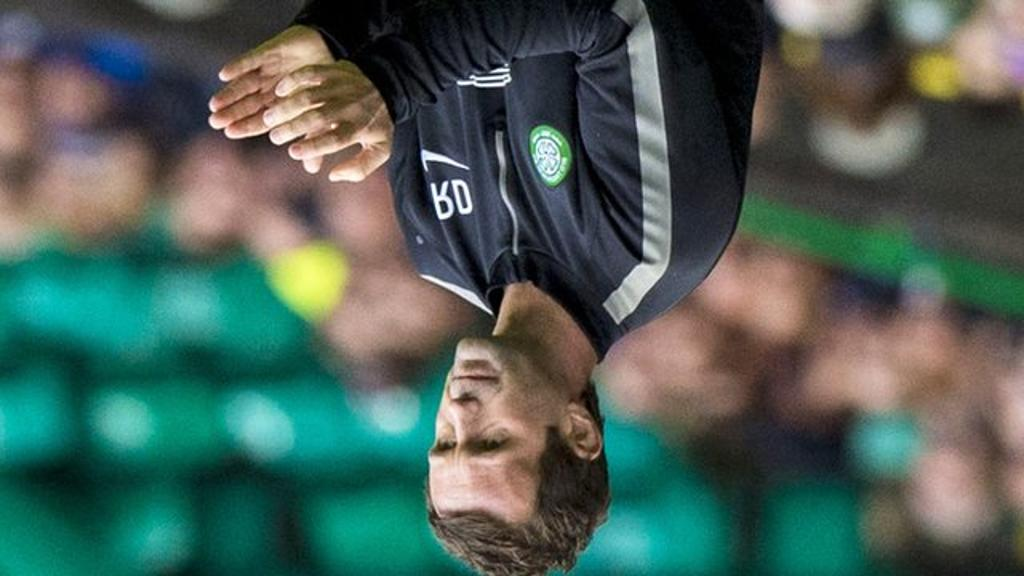

[]


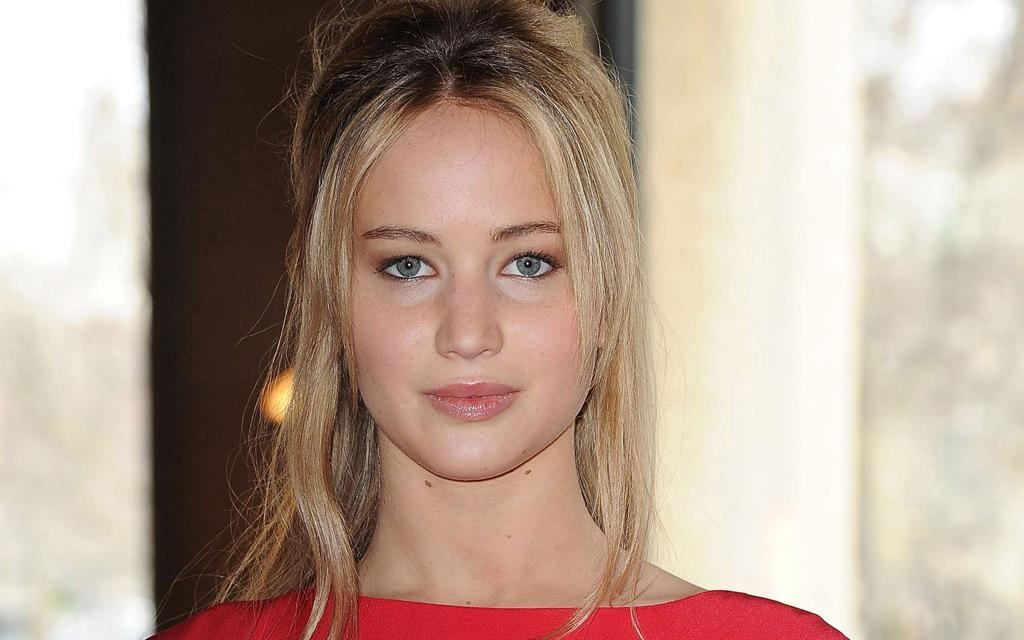

[{'box': [338, 129, 261, 341], 'confidence': 0.9967942833900452, 'keypoints': {'left_eye': (406, 267), 'right_eye': (531, 262), 'nose': (465, 340), 'mouth_left': (422, 395), 'mouth_right': (520, 393)}}]


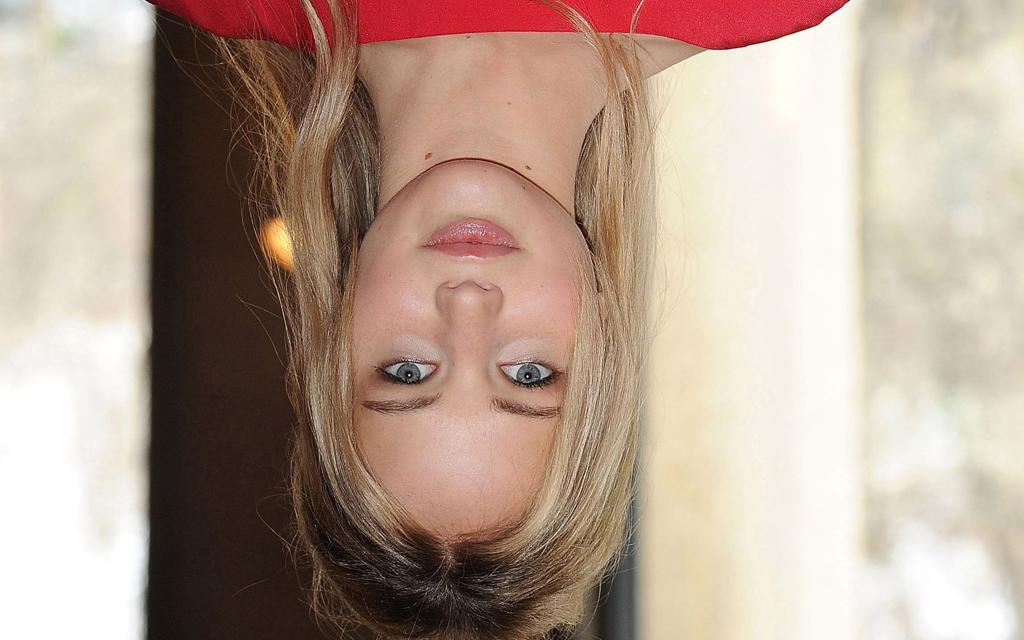

[]


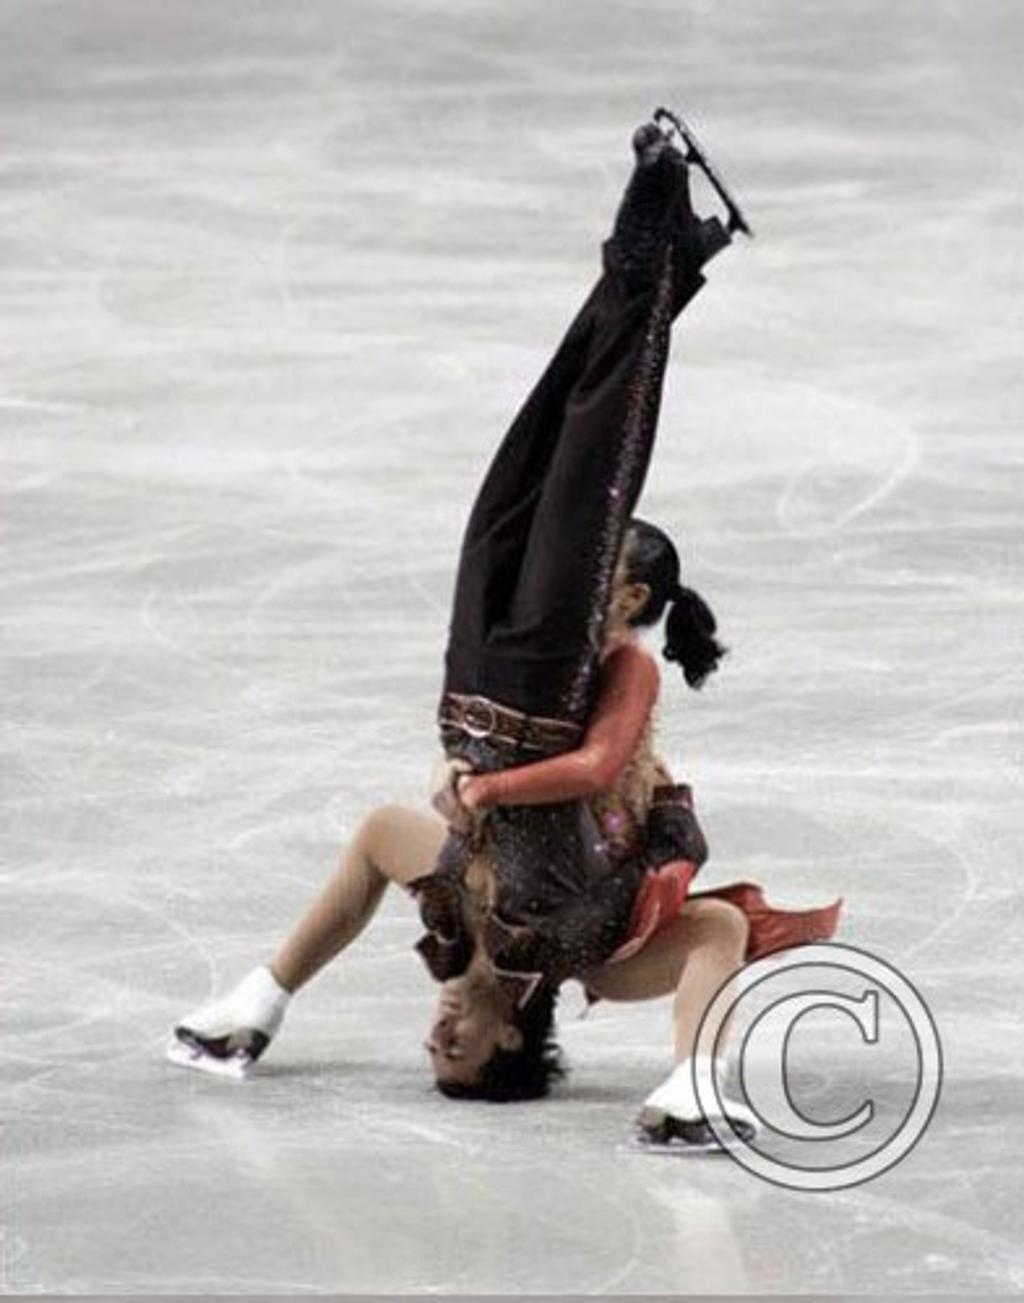

[]


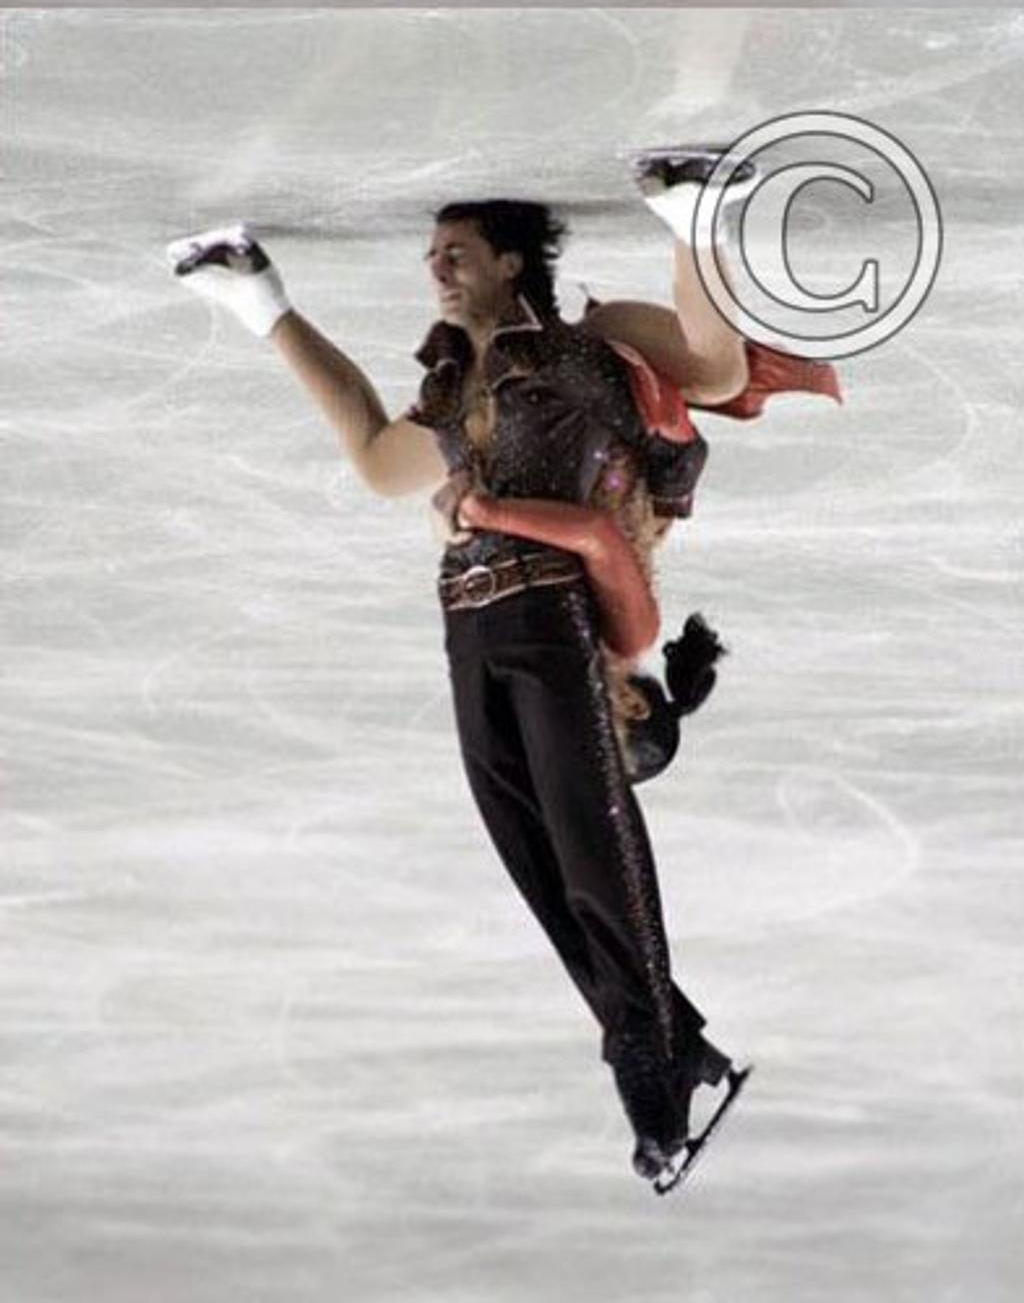

[{'box': [418, 221, 74, 95], 'confidence': 0.9893009066581726, 'keypoints': {'left_eye': (432, 258), 'right_eye': (458, 257), 'nose': (434, 274), 'mouth_left': (434, 294), 'mouth_right': (456, 294)}}]


In [ ]:
# mtcnn -- not able to detect inverted face image.
img_1 = cv2.imread('/content/drive/MyDrive/WIDERFACE/img1.jpg')
img_2 = cv2.imread('/content/drive/MyDrive/WIDERFACE/img2.jpg')
img_3 = cv2.imread('/content/drive/MyDrive/WIDERFACE/img3.jpg')

img1 = cv2.flip(img_1,0)
img2 = cv2.flip(img_2,0)
img3 = cv2.flip(img_3,0)

faceDetecter = MTCNN()
imgs = [img_1, img1, img_2, img2, img_3, img3]

for img in imgs:
  faces = faceDetecter.detect_faces(img)
  cv2_imshow(img)
  print(faces)

## ***Small-Scale mtcnn Model Creation and Training***

In [ ]:
# network/Factory

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, PReLU, Flatten, Softmax
from tensorflow.keras.models import Model, Sequential

import numpy as np

class PnetModel(Model):  
  def __init__(self):
    super().__init__()

    self.layer1 = Sequential(
        [
          Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid"),
          PReLU(shared_axes=[1, 2]),
          MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")
        ]
    )
    self.layer2 = Sequential(
        [
          Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid"),
          PReLU(shared_axes=[1, 2])
        ]
        
    )
    self.layer3 = Sequential(
        [
          Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid"),
          PReLU(shared_axes=[1, 2])
        ]
    )
    self.layer4 = Sequential(
        [
          Conv2D(2, kernel_size=(1, 1), strides=(1, 1)),
          Softmax(axis=3)
        ]
    )
    self.layer5 = Conv2D(4, kernel_size=(1, 1), strides=(1, 1))

  def call(self,inputs):
    out = self.layer1(inputs)
    out = self.layer2(out)
    out = self.layer3(out)
    
    out1 = self.layer4(out)
    out2 = self.layer5(out)

    return out1 #, out2  # -- out-2 (if used) willl be representing the bounding boxes co-ordinates

In [ ]:
def Preprocess(inputFile):
    train_face_split_path = inputFile

    train_data_files = []
    bounding_boxes = []

    with open(train_face_split_path) as f :
        prev_line = ''
        for lines in f:
            if lines == '1\n' : # Getting image_files with only one image.
                filename = prev_line
                bbx = f.readline()
                bbx = bbx[:-1].split(' ')[:4]
                bbx = [int(i) for i in bbx]
                train_data_files.append(filename[:-1])
                bounding_boxes.append(bbx)

            prev_line = lines
            if len(train_data_files) == 5000 :
                break
    return train_data_files, bounding_boxes

train_img_files, train_img_bxs = Preprocess('/content/drive/MyDrive/WIDERFACE/wider_face_split/wider_face_train_bbx_gt.txt')

print(len(train_img_files))
# print(train_img_files)
print(len(train_img_bxs))
# print(train_img_bxs)

4631
4631


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def getSamples(image,bbox):
  length = max(bbox[2]-bbox[0], bbox[3]-bbox[1])
  scales = [length/i for i in range(9,13)]
  height_ , width_  , _ = image.shape

  #print(f"Before scaling : height = {height_}, width = {width_} \n startx = {bbox[0]}, starty = {bbox[1]} \n len = {bbox[2]-bbox[0]} , height= {bbox[3]-bbox[1]}")
  Samples = []
  Boxs = []

  for scale in scales :
    new_height , new_width = int(np.ceil(height_/scale)) , int(np.ceil(width_/scale))
    img = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA)
    box = [int(i/scale) for i in bbox]

    # cv2.rectangle(img,
    #               (box[0],box[1]),
    #               (box[2],box[3]),
    #               (0,155,255),
    #               2)
    # cv2_imshow(img)
    # print(f"after scaling_{scale} : height = {img.shape[0]}, width = {img.shape[1]} \n startx = {box[0]}, starty = {box[1]} \n len = {box[2]-box[0]} , height= {box[3]-box[1]}")

    Samples.append(img)
    Boxs.append(box)

  return Samples, Boxs

img_data = []
box_data = []

image_files_path = '/content/drive/MyDrive/WIDERFACE/WIDER_train/images/'
for i,imageFile in enumerate(train_img_files):
  image = cv2.imread(image_files_path + imageFile)
  bBox = [j for j in train_img_bxs[i]]
  bBox[2]+=bBox[0]
  bBox[3]+=bBox[1]

  images1,bBox1 = getSamples(image,bBox)
  for j,img in enumerate(images1):
    img_data.append(img)
    box_data.append(bBox1[j])

  # cv2.rectangle(image,
  #               (bBox[0],bBox[1]),
  #               (bBox[2],bBox[3]),
  #               (0,155,255),
  #               2)
  # cv2_imshow(image)

  if i == 500:
    break

# -- img_data length = 4*(i+1) ,, i=500 ==> 2004  img_data
print(len(img_data))
print(len(box_data))

print(img_data[0].shape)
print(box_data[0])

2004
2004
(84, 62, 3)
[27, 19, 34, 28]


In [ ]:
def getPNetSamples(image,bbox):
  height, width, _ = image.shape

  posSamples = []
  negSamples = []

  for i in range(height-12):
    for j in range(width-12):
      if i<=bbox[0] and j<=bbox[1] and i+12>=bbox[2] and j+12>=bbox[3] :  # FaceBox completely inside of 12x12 sample
        posSamples.append(image[i:i+12,j:j+12,:])

  npos = len(posSamples)
  
  for i in range(height-12):
    if npos<=0: break
    for j in range(width-12):
      if npos<=0: break
      if i>bbox[2] or i+12<bbox[0] or j>bbox[3] or j+12<bbox[1] : # No intersection of Box and 12x12 sample.
         negSamples.append(image[i:i+12,j:j+12,:])
         npos-=1  

  return posSamples, negSamples


X_data = []
y_data = []

#image_files_path = '/content/drive/MyDrive/WIDERFACE/WIDER_train/images/'
print("Total img_data length = ", len(img_data))
for i, image in enumerate(img_data):
  bBox = [j for j in box_data[i]]
  pos,neg = getPNetSamples(image,bBox)

  X_data.extend(pos)
  y_data.extend([1 for _ in range(len(pos))])
  X_data.extend(neg)
  y_data.extend([0 for _ in range(len(neg))])

  if i==1000:
    break

# in total we have 2004 of img_data
# -- using first 200 of img_data, we get 4552 images of 12x12
# -- using first 500 of img_data, we get 10842 images of 12x12
print("Final X_data length",len(X_data))
print("Final y_data length",len(y_data))

Total img_data length =  2004
Final X_data length 18974
Final y_data length 18974


In [ ]:
from sklearn.model_selection import train_test_split

X_dataset, y_dataset = np.array(X_data),np.array(y_data)
X_dataset ,y_dataset = X_dataset.astype("float32"), y_dataset.astype("float32")
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset,test_size=0.3)

print(f"Training data -- #(X_train) = {len(X_train)} , #(y_train) = {len(y_train)}")
print(f"Testing data -- #(X_train) = {len(X_test)} , #(y_train) = {len(y_test)}")

Training data -- #(X_train) = 13281 , #(y_train) = 13281
Testing data -- #(X_train) = 5693 , #(y_train) = 5693


In [ ]:
model = PnetModel()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# y_train_one_hot = tf.one_hot(y_train,depth=2)
model.fit(X_train, y_train, 
          batch_size=64,
          epochs=10
)

Epoch 1/10
208/208 [==============================] - 3s 10ms/step - loss: 1.9939 - sparse_categorical_accuracy: 0.5033
Epoch 2/10
208/208 [==============================] - 2s 10ms/step - loss: 1.1146 - sparse_categorical_accuracy: 0.5046
Epoch 3/10
208/208 [==============================] - 2s 10ms/step - loss: 0.9120 - sparse_categorical_accuracy: 0.5035
Epoch 4/10
208/208 [==============================] - 2s 10ms/step - loss: 0.8035 - sparse_categorical_accuracy: 0.5047
Epoch 5/10
208/208 [==============================] - 2s 10ms/step - loss: 0.7288 - sparse_categorical_accuracy: 0.5061
Epoch 6/10
208/208 [==============================] - 2s 10ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.5053
Epoch 7/10
208/208 [==============================] - 2s 10ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.5067
Epoch 8/10
208/208 [==============================] - 2s 10ms/step - loss: 0.6075 - sparse_categorical_accuracy: 0.5047
Epoch 9/10
208/208 [====================

In [ ]:
test_loss , test_acc = model.evaluate(X_test, y_test, verbose=2)

178/178 - 1s - loss: 0.5846 - sparse_categorical_accuracy: 0.5118 - 612ms/epoch - 3ms/step


In [ ]:
def getInvertedSamples(X,y):
  X_inv = []
  y_inv = []

  for i,img in enumerate(X) :
    X_inv.append(img)
    y_inv.append(y[i])
    X_inv.append(cv2.flip(img,0))
    y_inv.append(y[i])

  return X_inv, y_inv

new_X_data, new_y_data = getInvertedSamples(X_data,y_data)
print(f"Total Length of image dataset after adding inverted samples = {len(new_X_data)}")
print(f"Total Length of image labels after adding inverted samples = {len(new_y_data)}")

Total Length of image dataset after adding inverted samples = 37948
Total Length of image labels after adding inverted samples = 37948


In [ ]:
new_X_dataset, new_y_dataset = np.array(new_X_data),np.array(new_y_data)
new_X_dataset ,new_y_dataset = new_X_dataset.astype("float32"), new_y_dataset.astype("float32")
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X_dataset, new_y_dataset,test_size=0.3)

print(f"new Training data -- #(X_train) = {len(X_train2)} , #(y_train) = {len(y_train2)}")
print(f"new Testing data -- #(X_train) = {len(X_test2)} , #(y_train) = {len(y_test2)}")

new Training data -- #(X_train) = 26563 , #(y_train) = 26563
new Testing data -- #(X_train) = 11385 , #(y_train) = 11385


In [ ]:
model2 = PnetModel()
model2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# y_train_one_hot = tf.one_hot(y_train,depth=2)
model2.fit(X_train2, y_train2, 
          batch_size=64,
          epochs=10
)

Epoch 1/10
416/416 [==============================] - 5s 10ms/step - loss: 1.0283 - sparse_categorical_accuracy: 0.5037
Epoch 2/10
416/416 [==============================] - 4s 9ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.5052
Epoch 3/10
416/416 [==============================] - 4s 9ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.5064
Epoch 4/10
416/416 [==============================] - 4s 9ms/step - loss: 0.6135 - sparse_categorical_accuracy: 0.5059
Epoch 5/10
416/416 [==============================] - 4s 9ms/step - loss: 0.5997 - sparse_categorical_accuracy: 0.5056
Epoch 6/10
416/416 [==============================] - 4s 9ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.5061
Epoch 7/10
416/416 [==============================] - 4s 10ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.5059
Epoch 8/10
416/416 [==============================] - 4s 10ms/step - loss: 0.5673 - sparse_categorical_accuracy: 0.5062
Epoch 9/10
416/416 [=========================

In [ ]:
# Accuracy results of the model trained on both straight and inverted images
test_loss2 , test_acc2 = model2.evaluate(X_test2, y_test2, verbose=2)

356/356 - 1s - loss: 0.5528 - sparse_categorical_accuracy: 0.5089 - 1s/epoch - 4ms/step


In [ ]:
# Accuracy result of the model trained mostly on straight images.
test_loss3 , test_acc3 = model.evaluate(X_test2, y_test2, verbose=2)

356/356 - 1s - loss: 0.6830 - sparse_categorical_accuracy: 0.5111 - 888ms/epoch - 2ms/step


* In the above section, We have two small scale mtcnn models trained
* One is trained on images taken directly from the image dataset used to train the real mtcnn model
* In the second one we have trained the model using images from the same former dataset and also their flipped versions.
* It was obersved there isn't much improvement in training the model for inverted face images
* To make the model robust for input images flipping and rotation configurations, pre-training the model is not effective.

## ***Affine Transformations***

* A simple solution to the above problem is to send both the image and inverted image to an already trained mtcnn model, rather than training the mtcnn model with both images and their inverted versions.
* Affine transformations are geometric transformations that preserves the lines and parallelism in but not necessarily the distances and angles.
* We have read about affine transformations being used after face detection and before sending the data into face recognition models, thus making the models more robust.  
Refered from : https://ieeexplore.ieee.org/abstract/document/9743217
* The addition of using face normalization and affine transformations will improve our models robustness in the face detection step also.

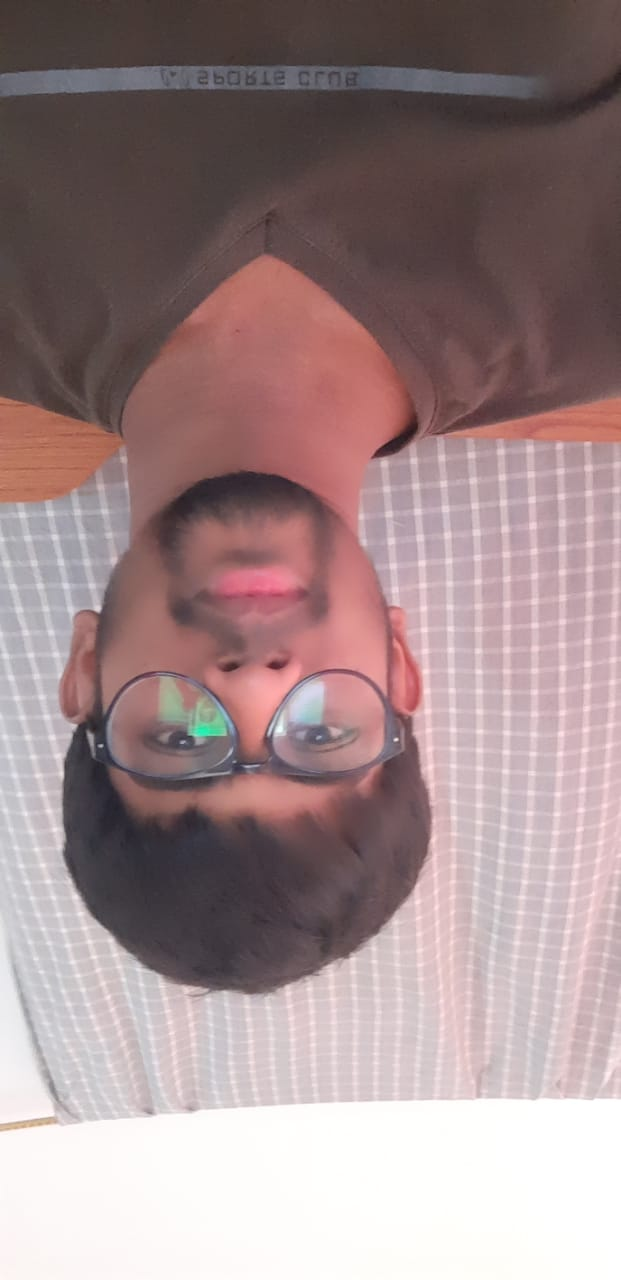

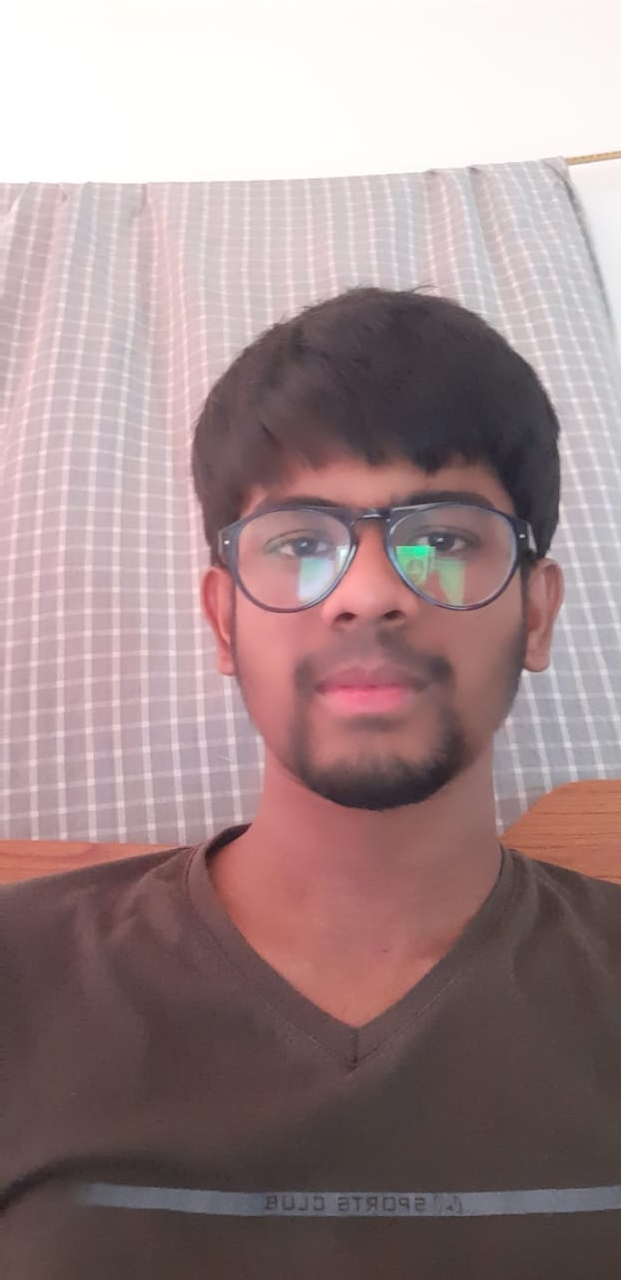

In [ ]:
# Making a simple Affine transformation, flipping/inverting the image
myimg = cv2.imread('/content/drive/MyDrive/WIDERFACE/img.jpeg')
myimg = cv2.flip(myimg,0)

aff_trans = tf.keras.preprocessing.image.apply_affine_transform(
              myimg,
              theta=180
            )

# Im
cv2_imshow(myimg)
cv2_imshow(aff_trans)

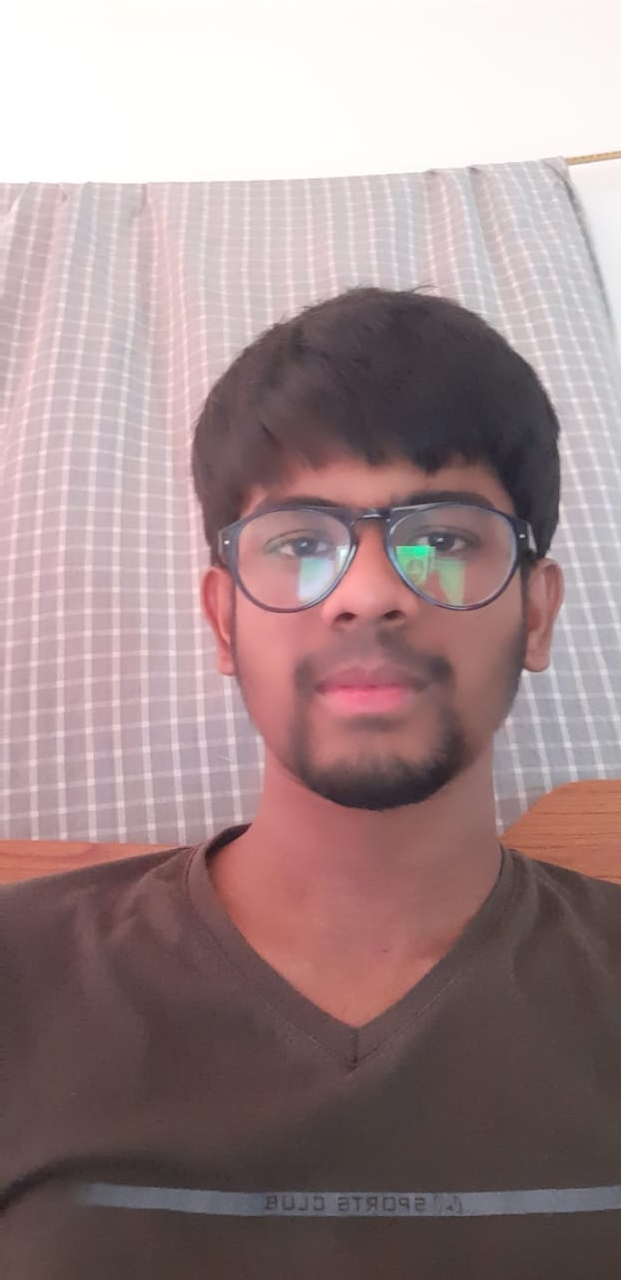

[{'box': [213, 416, 299, 362], 'confidence': 0.9997088313102722, 'keypoints': {'left_eye': (298, 538), 'right_eye': (440, 540), 'nose': (366, 601), 'mouth_left': (303, 682), 'mouth_right': (433, 687)}}]


In [ ]:
# Checking the output of mtcnn face detector.
# Model able to detect the Face in the image, (with 0.98 confidence!)
faces = faceDetecter.detect_faces(aff_trans)
cv2_imshow(aff_trans)
print(faces)

## ***Code Delineation***

**Pre-Trained mtcnn Model Usage**  
Harsha (cs19btech110023) and Sushma (cs19btech11006) 

**Small-Scale mtcnn Model Creation and Training**  
Sanjay (cs19btech11013) -- CNN architecture code  
Sushma (cs19btech11006) -- Basic Preprocessing of Files  
Sehouriey (cs19btech11015) -- Completing the preprocessing step(Image scaling, positive and negative samples generation)  
Sushma (cs19btech11006) -- Generation of inverted samples  
Sanjay (cs19btech11013) -- Training the two models on generated datasets

**Affine Transformations**  
Sehouriey (cs19btech11015) and Harsha (cs19btech11023)
